# Détection du COVID-19 avec Deep Learning

Ceci n'est pas un test diagnostique du coronavirus, mais un proof-of-concept. Pourque cela aboutit, il faut plus d'invesstissment, à la fois sur la colelcte de données, et sur l'examination de la cohérence entre le modèle et les connaissance sanitaire, radiologique, ...


## 0. Introduction

### 0.1 Compréhension de la problématique

**Contexte actuel**: On peut réutiliser les billets déjà diffusés d'Addactis. 

**Quel problème résout ce travail?**

On souhaite détecter la présence du coronavirus dans le poumon d'une personne grâce à son scan pulmonaire. Ce type de scan est rapide et relativement facile à réaliser en complément à l'examen clinique, sans être un test de détection virale à proprement parler.  

Une difficulté est le manque des données (les images du scan des poumons). On doit entrainer notre modèle sur une petite base de données, et l'évaluer sur une échantillon encore plus petite. Pour palier ce problème, une technique de data augmentation va être utilisé afin d'augmenter la taille de la base de données de manière fictive.


### 0.2. Que sait-on du domaine?
#### Les types de tests
Les tests de dépistage jouent un role primordial dans la lutte contre le coronavirus. Il existes actuellement 3 types de tests:

* les **tests biologiques PCR** (réaction en chaîne par polymérase):  Un écouvillon (une sorte de long coton-tige) est introduit dans la narine du patient pour prélever des cellules nasales profondes. Cet échantillon est ensuite analysé en laboratoire spécialisé pour rechercher la présence de brins d'ARN appartenant au virus SARS-CoV-2 et confirmer ou non le diagnostic.  

* les tests **acide nucléique**: le délai d'exécution est entre la réception de l'échantillon et le résultat du test est de 36 heures. Il est plus cher que les tests RT-PCR.  

* les tests **antigéniques**: Ces tests donnent un résultat en 30 minutes, et sont basés sur la recherche d'antigènes du virus. 

* les tests **sérologiques**: ils détectent la présence d'anticorps de classe IgG dans le sang.

* les **scan pulmonaire**: la lecture des images des scan donne un indicateur de la présence du COVID-19 dans le poumons d'une personne.

#### La fiabilité des tests:

Il s'agit d'un indicateur important des tests. Un test non fiable est un danger potentiel car les gens pouvaient alors penser qu'ils étaient immunisés contre le virus alors qu'ils étaient encore vulnérables. Un résultat de test fiable pour confirmer la guérisson du coronavirus est en contre partie très précieux, et permet une personne à revenir à sa vie normale, sans nécesscité de se mettre en quarantaine.

* les **tests biologiques PCR** il s'agit des tests PCR les plus utilisés pour le dépistage du coronavirus. La fiabilité de ces tests ainsi que la manière d'effectuer les prélèvements naso-pharyngés commencent à être questionnés. En effet, au bout de quelques jours, la charge virale dans le nez d'un patient atteint pourrait être nulle, car le virus se déplace progressivement vers les voies respiratoires.  


* les tests **antigéniques**: Ils ont une sensibilité assez modeste (60,2 %) et une très bonne spécificité (99,2 %). Le résultat du test ne permet donc pas d'affirmer avec une bonne fiabilité quand sortir de l'isolement (ou par anticipation d'une décision générale de confinement), sauf si le test est confirmé par des symptômes cliniques indiscutables. Le malade peut alors dans ce cas sortir de l'isolement 25 jours après le début de la maladie.

* les tests **sérologiques**: ils détectent la présence d'anticorps de classe IgG dans le sang. Ils ont une très bonne spécificité (100 %), mais une sensibilité maximale de 70 % (après la période d'incubation de 10 jours). La sensibilité théorique est sans doute un peu moins élevée dans la population plus âgée, à cause du phénomène d'immunosénescence.

* les **scan pulmonaire**: Une recherche a révélé que la sensibilité de la méthode pour la détection de la Covid-19 était de 98 %, à comparer à une sensibilité de 71 % pour la RT-PCR.


### 0.2 Que serait notre proposition?

Dans cette étude, on souhaite automatiser et fiabiliser le test en utilisant le scan pulmonaire. Etant donné une image du scan, une probabilité d'avoir le covid-19 variant entre $[0, 1]$ va être donnée par un modèle d'apprentisage automatique qui analyse en détails les différents pixels de l'image. 

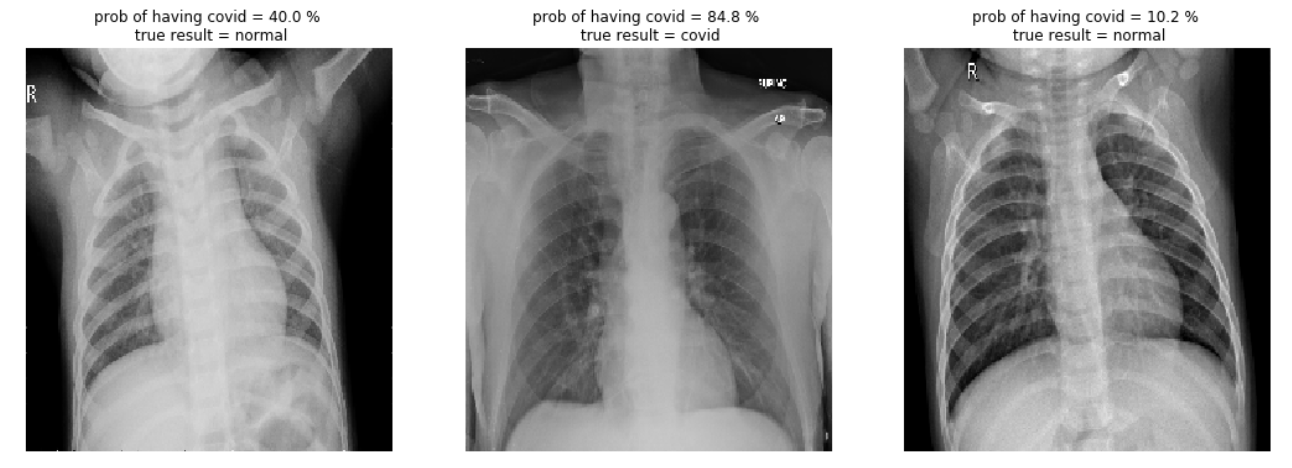

Dans le futur, avec plus de données, un score de sévérité peut être enviagé en utilisant un mécanique similaire. Cela est sans doute une information utile dans le traitement des personnes malades.


## 1. Environnement 

### 1.1. Les modules utiles
Nous importons tous les outils nécessaires pour notre travail.

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import shutil
import cv2
import os
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
from sklearn.metrics import plot_confusion_matrix

### 1.2 helper functions

In [2]:
def pie_plot(df, col, title, show = True, width=450, height=450):
    """
    this function calculate the frequency table of column 'col' and plot a pie plot.
    
    Parameters
    ----------
        df: a pandas data frame.
        col: string, the column to be plotted
        title: string, the title of the pie graph
        show: boolean, if True: execution of the function shows the pie plot
        width: float, width of the plot
        height: float, height of the plot

    Returns
    -------
        an interactive pie plot
    """
    stat_ = df[col].value_counts().rename_axis(col).reset_index(name='freq')
    fig = px.pie(stat_, values='freq', names=col, title=title, width=width, height=height)
    if show:
        fig.show()
    if not show:
        return go.Pie(labels=stat_[col], values=stat_['freq'])
    
def data_augmentation_show(aug_engine, image):
    """
    this function shows the result of a data augmentation on an image.
    
    Parameters
    ----------
        aug_engine: a data generator object
        image: the image on which aug_engine is applied

    Returns
    -------
        a plot of different images generated
    """
    it = aug_engine.flow(image, batch_size=1)
    # generate samples and plot
    for i in range(9):
        pyplot.subplot(330 + 1 + i)
        batch = it.next()
        image = batch[0]
        pyplot.imshow(image)
    # show the figure
    pyplot.show()
    
def data_show(image_path):
    """
    this function shows the sample of data on image_path.
    
    Parameters
    ----------
        image_path: string, path to the images to be shown

    Returns
    -------
        a 2x5 plot of images whose path is in image_path
    """
    f, ax = plt.subplots(2,5, figsize=(20,6))
    for i in range(10):
        img = cv2.imread(image_path[i])
        ax[i//5, i%5].imshow(img, cmap='gray')
        if i<5:
            ax[i//5, i%5].set_title("Covid-19")
        else:
            ax[i//5, i%5].set_title("Normal")
        ax[i//5, i%5].axis('off')
        ax[i//5, i%5].set_aspect('auto')
    plt.show()
    
    
def data_construction(image_paths):
    """
    this function appends all images found in image_paths to construct an unique data base for tensorflow
    
    Parameters
    ----------
        image_paths: list of string, paths to the images of the data base

    Returns
    -------
        a clean data base containing the images in the image_paths, and their labels.
    """
    data = []
    labels = []
    for image_path in image_paths:
        label = image_path.split(os.path.sep)[-2]
        image = cv2.imread(image_path) # lecture de l'image
        image = cv2.resize(image, (224, 224)) # resize
        data.append(image)
        labels.append(label)

    # normaliser les images
    data = np.array(data) / 255.0
    labels = np.array(labels)
    return data, labels

## 2. Les données

**Covid images**: https://github.com/ieee8023/covid-chestxray-dataset. Ce repo contient des images des rayons X ou des tomographies des patients du Covid-19, et d'autres pneumonies virales et bactériennes (MERS, SRAS et SDRA). Les données sont recueillies auprès de sources publiques ainsi que par le biais d'une collecte indirecte auprès des hôpitaux et des médecins.  
**Normal images**: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

Un fichier metadata est inclu dans ce repo, il contient les informations utiles relativement à chaque image. 

In [3]:
df = pd.read_csv("C:/Quang/Covid_19/metadata.csv")
df.sample(n=3, random_state = 1)

patientid  offset  sex   age   finding survival intubated  \
102         51     3.0    M  47.0  COVID-19        Y       NaN   
125         64     NaN  NaN   NaN  COVID-19      NaN       NaN   
11           3    10.0    M  74.0      SARS        N       NaN   

    intubation_present went_icu needed_supplemental_O2  ...           date  \
102                NaN      NaN                    NaN  ...  March 4, 2020   
125                NaN      NaN                    NaN  ...           2020   
11                 NaN      NaN                    NaN  ...           2004   

                                           location  folder  \
102                                           Italy  images   
125                                             NaN  images   
11   Mount Sinai Hospital, Toronto, Ontario, Canada  images   

                                              filename                    doi  \
102          D5ACAA93-C779-4E22-ADFA-6A220489F840.jpeg                    NaN   
125                            kjr-21-e24-g002-l-c.jpg  10.3348/kjr.2020.0132   
11   SARS-10.1148rg.242035193-g04mr34g0-Fig8c-day10...   10.1148/rg.242035193   

                                                   url      license  \
102  https://www.sirm.org/2020/03/10/covid-19-caso-34/          NaN   
125  https://www.kjronline.org/DOIx.php?id=10.3348/...  CC BY-NC-SA   
11      https://pubs.rsna.org/doi/10.1148/rg.242035193          NaN   

                                        clinical_notes  \
102  Male patient, 47 years old. Remote history cha...   
125  COVID-19 pneumonia manifesting as confluent pu...   
11   SARS in a 74-year-old man who developed sympto...   

                                           other_notes Unnamed: 27  
102  Credit to G.Patelli , F.Besana , S. Paganoni *...         NaN  
125                                                NaN         NaN  
11                                                 NaN         NaN  

[3 rows x 28 columns]

Baser sur l'examination de la répartition de type de la maladie, on peut constater que Covid-19 est la maladie la plus populaire dans cette base de données avec 262 scans pulmonaires COVID-19.

In [4]:
pie_plot(df, "finding", "type of illness", width=500, height=500)   

On peut regarder également le type de vue du scan

In [5]:
pie_plot(df, 'view', 'type of scan')

En radiologie, il y a principalement 2 types de vue:

* "AP view": pendant la procédure de prise de radiographie aux rayons X lorsque les rayons X passent de la partie postérieure du corps à la partie antérieure, on parle de "AP view".  
* "PA view": la direction est opposée.

Pour conserver l'homogénéité des données, on s'intéresse uniquement à la "AP view" dans ce notebook (56.8% de la base de données). Dans un futur travail, on peut examiner simultanement les vues afin d'avoir une diagnostique plus fiable.

La section suivante nous montre la répartition des ages des malades du COVID-19 versus les autres maladies.

In [6]:
df['maladie'] = np.where(df['finding'] == "COVID-19", "covid", "other")
fig = px.histogram(df, x="age", color="maladie")
fig.show()

On peut remarquer que les personnes agées ayant plus de 50 ans prédominent la population des malades.

In [7]:
df['country'] = df['location'].str.rsplit(',').str[-1] 
pie_plot(df, "country", "countries of patient", height=550, width=650)   

Les trois pays les plus touchés par le COVID-19 ont plus de scans pulmonaires dans notre base de données.

## 3. Construction de la base de données

Deux types des images sont à notre disposition: 

* les images des personnes atteintes du Covid-19  
* les images des personnes non-atteintes du Covid-19

Dans cette section, on va ranger proprement ces images dans notre répertoire de travail.

### 3.1. Données Covid-19

In [8]:
df = df[df["view"] == "PA"]
df_covid = df[df["finding"] == "COVID-19"]

In [9]:
dataset_path = 'C:/Quang/Covid_19/dataset'
covid_dataset_path = 'C:/Quang/Covid_19/images'

for (i, row) in df_covid.iterrows():
    covid_path = f"{covid_dataset_path}/{row['filename']}"
    output_path = f"{dataset_path}/covid/{row['filename'].split(os.path.sep)[-1]}"
    shutil.copy2(covid_path, output_path) #copy the image

### 3.2. Données normales

On tire au hasard 50 images des personnes normales, et les coipe ensuite vers notre dossier de travail

In [10]:
normal_paths = list(paths.list_images('C:/Quang/Covid_19/chest_xray/train/NORMAL'))
# on sélectionne aléatoirement les images normales
samples = 50
random.seed(1) # pour la réproductivité de notebook
normal_paths = random.sample(normal_paths, samples)
for (i, normal_path) in enumerate(normal_paths):
    output_path = f"{dataset_path}/normal/{normal_path.split(os.path.sep)[-1]}"
    shutil.copy2(normal_path, output_path)

### 3.3 La base de données centralisées

On peut visualiser les images de notre base de données. Dans ce notebook, on va essayer de classifier une image Covid / normal, et donner la probabilité d'une personne ayant le covid 19 sachant son scan.

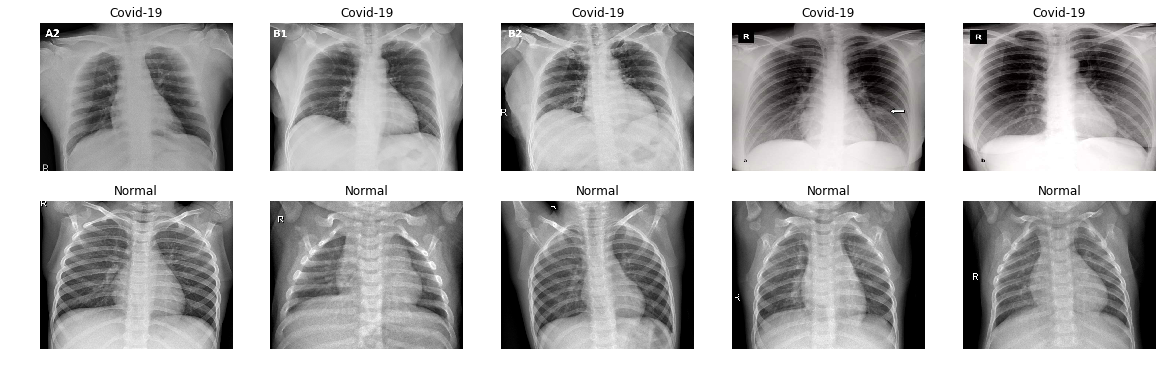

In [11]:
covid_paths = list(paths.list_images(dataset_path + "/covid"))[10:15]
normal_paths = list(paths.list_images(dataset_path + "/normal"))[10:15]
sample = covid_paths + normal_paths

# Plot the data 
data_show(sample)

## 4. Data preprocessing

In [12]:
image_paths = list(paths.list_images(dataset_path))
data, labels = data_construction(image_paths)

### Data augmentation

Toutes les images ne sont pas exactement du même types. On peut remarquer dans le graphique d'avant que chaque image a un niveau de rotation différent. Dans cette partie, une technique de data augmentation est appliquée pour but d'avoir plus de données dans notre base de données d'entrainement. Nous allons appliquer seulement l'option rotation afin d'augmenter la répensentativité de la base de données.

La data augmentation est appliquée uniquement sur la base d'entrainement, et pas sur la base de validation.

In [13]:
# one-hot encoding pour les labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
# split les données en training & testing set
test_percentage = 0.2
(x_train, x_test, y_train, y_test) = train_test_split(data, labels, test_size=test_percentage, 
                                                  stratify=labels, random_state=42)
# application de data augmentation
augmentator = ImageDataGenerator(rotation_range=15, fill_mode="nearest")

Nous pouvons voir le résultat de notre data augmentation sur une image comme suivant:

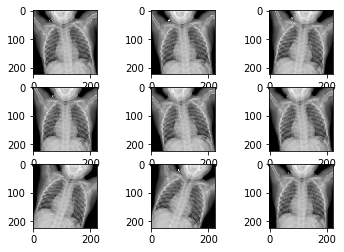

In [14]:
from matplotlib import pyplot
# create image data augmentation generator
data_augmentation_show(augmentator, x_train[[1]])

Une image est tournée de manière aléatoire pour avoir plus d'image dans notre training set.

## 5. Transfer learning

On va réutilisé un réseau de neurones artificiels très sophistiqué déjà entrainés sur des millions des images. L'avantage du transfer learning sont:

* **qualité**: cela permet de conserver la connaissance du réseaux déjà acquis pendant la phase de pré-entrainement
* **économie du temps**: il s'agit souvent des réseaux très sophistiqués, avec des milliers voire millions de paramètres, déjà entrainés des bases de données.

En plus, le transfer learning est particulièrement adapté à notre problème. Habituellement, beaucoup de données sont nécessaires pour entrainer un réseau de neurones sophistiqué, mais l'accès à ces données n'est pas toujours disponible - c'est là que transfer learning est utile. Avec cette technique, un modèle solide peut être construit avec relativement peu de données car le modèle est déjà pré-entrainé.

Dans cette section, nous allons utiliser le modèle **VGG19**. Le choix du modèle est arbitraire.


In [15]:
from tensorflow.keras.applications import VGG19
baseModel = VGG19(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
# On va ajouter les couches supplémentaires afin d'adapter le modèle VGG19 à notre problématique
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(32, activation="relu")(headModel)
headModel = Dropout(0.3)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)

# On ne va pas changer les paramètre du modèle de base
for layer in baseModel.layers:
    layer.trainable = False

On a choisi un architechture du modèle très simple car on n'a pas beaucoup de données. On peut ensuite entrainer notre réseau de neurones: 

In [16]:
lr = 1e-5
epoch = 15
bs = 16

# compile our model
optimizer = Adam(lr=lr, decay=lr / epoch)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# train the head of the network
H = model.fit(
    augmentator.flow(x_train, y_train, batch_size=bs),
    steps_per_epoch  = len(x_train) // bs,
    validation_data  = (x_test, y_test),
    validation_steps = len(x_test) // bs,
    epochs           = epoch)

  ...
    to  
  ['...']
Train for 8 steps, validate on 36 samples
Epoch 1/15
8/8 [==============================] - 35s 4s/step - loss: 1.4029 - accuracy: 0.2441 - val_loss: 0.6975 - val_accuracy: 0.3125
Epoch 2/15
8/8 [==============================] - 37s 5s/step - loss: 0.6651 - accuracy: 0.6220 - val_loss: 0.4994 - val_accuracy: 0.7500
Epoch 3/15
8/8 [==============================] - 42s 5s/step - loss: 0.6839 - accuracy: 0.6614 - val_loss: 0.4827 - val_accuracy: 0.7500
Epoch 4/15
8/8 [==============================] - 37s 5s/step - loss: 0.5534 - accuracy: 0.7087 - val_loss: 0.4537 - val_accuracy: 0.7500
Epoch 5/15
8/8 [==============================] - 38s 5s/step - loss: 0.6022 - accuracy: 0.7165 - val_loss: 0.4076 - val_accuracy: 0.7500
Epoch 6/15
8/8 [==============================] - 40s 5s/step - loss: 0.5274 - accuracy: 0.7559 - val_loss: 0.3767 - val_accuracy: 0.7500
Epoch 7/15
8/8 [==============================] - 38s 5s/step - loss: 0.5632 - accuracy: 0.7480 - val_los

## 6. Visualisation des résultats 
### 6.1 Train & loss accuracy

In [17]:
fig = go.Figure()
x_ = list(range(0, epoch))
fig.add_trace(go.Scatter(x=x_, y=H.history['loss'], 
                         name="training loss", line=dict(color='#EF553B')))
fig.add_trace(go.Scatter(x=x_, y=H.history['accuracy'], 
                         name="training accuracy", line=dict(color='#00CC96')))
fig.add_trace(go.Scatter(x=x_, y=H.history['val_loss'], name="validation loss", line=dict(color='#EF553B', dash="dash")))
fig.add_trace(go.Scatter(x=x_, y=H.history['val_accuracy'], name="validation accuracy", line=dict(color='#00CC96', dash="dash")))
fig.update_layout(
    title={'text': "Train & loss accuracy on Covid dataset",
           'y':0.9,
           'x':0.5,
           'xanchor': 'center',
           'yanchor': 'top'},
    xaxis_title="# epoch",
    yaxis_title="performance"
)

Avec un architechture simple, collé au-dessus du modèle VGG19 avec 19 couches, on arrive à avoir un classifieur assez performant sur la base de données du COVID-19, avec un niveau de précision élevé ~ 95%.

Examinons en suite d'autres KPIs de notre classifieur: 

### 6.2 Classification report

In [18]:
pred_prob = model.predict(x_test, batch_size=bs)
pred_diag = np.argmax(pred_prob, axis=1)
from sklearn.metrics import classification_report
print(classification_report(y_test.argmax(axis=1), pred_diag, target_names=lb.classes_))

              precision    recall  f1-score   support

       covid       0.93      1.00      0.96        26
      normal       1.00      0.80      0.89        10

    accuracy                           0.94        36
   macro avg       0.96      0.90      0.93        36
weighted avg       0.95      0.94      0.94        36



In [19]:
# accuracy, sensitivity, and specificity
cm = confusion_matrix(y_test.argmax(axis=1), pred_diag)
print(cm)

[[26  0]
 [ 2  8]]


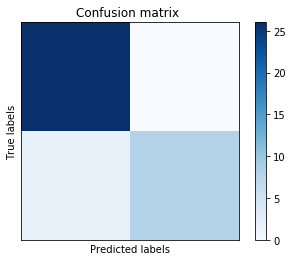

In [20]:
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()

### 6.3 Délivrables

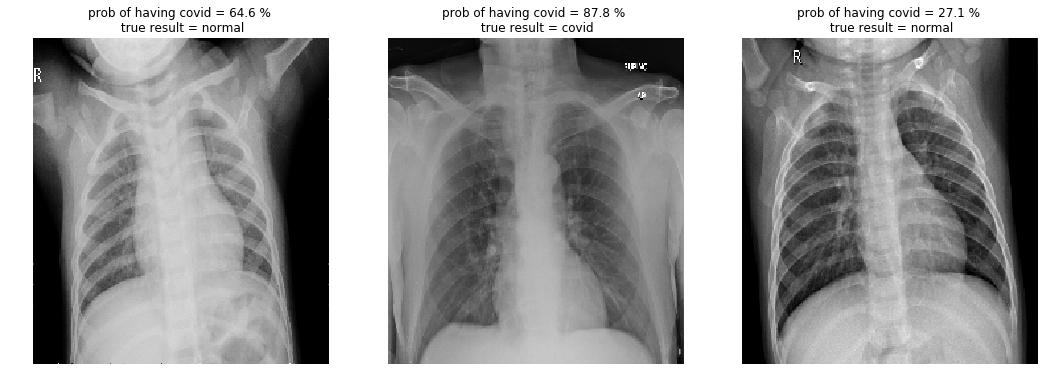

In [21]:
im_num = [8, 9, 16]
f, ax = plt.subplots(1, len(im_num), figsize=(6*len(im_num),6))
for dex, i in enumerate(im_num):
    ax[dex].imshow(x_test[i])
    if y_test[i][0] == 1:
        result = "covid"
    else:
        result = 'normal'
    ax[dex].set_title(f"prob of having covid = {np.round(pred_prob[i][0]*100,1)} % \n true result = {result}")
    ax[dex].axis('off')
    ax[dex].set_aspect('auto')
plt.show()